# Temperature Test

In [14]:
import numpy as np
import pandas as pd


In [15]:
temp_df = pd.read_csv("data/Temperature Data.csv")
pop_df = pd.read_csv("data/Population Data.csv")

In [16]:
temp_df.head()

,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c
0,Atlanta,UnitedStates,USA,North America,KATL,4/20/2021,17.491667,12.2,23.3
1,Windsor Locks,UnitedStates,USA,North America,KBDL,4/20/2021,13.887500,3.9,22.2
2,Nashville,UnitedStates,USA,North America,KBNA,4/20/2021,15.175000,6.7,23.3
3,Boise,UnitedStates,USA,North America,KBOI,4/20/2021,9.329167,1.7,15.6
4,Boston,UnitedStates,USA,North America,KBOS,4/20/2021,16.716667,10.0,23.9


In [17]:
pop_df.head()

,City,State,population,Lon,Lat
0,Henderson,Nevada,260068,-115.0375,36.0122
1,Manchester,New Hampshire,109830,-71.4439,42.9847
2,Elizabeth,New Jersey,125660,-74.1935,40.6663
3,Newark,New Jersey,277540,-74.1726,40.7242
4,Paterson,New Jersey,146427,-74.1628,40.9147


In [18]:
# Setting correct data types
temp_df.location_date = pd.to_datetime(temp_df.location_date)


## Computing Population Weights

Data in `Temperature Data.csv` is recorded by airport. Data in `Population Data.csv` is recorded by City. Forcing the join by city nearest the airport is best place to start. 

Let's try to count an accurate population to airports rather than just assuming the city and not surrounding areas should count towards the population weighting

In [51]:
import airportsdata

In [56]:
airports = pd.DataFrame(airportsdata.load()).T

In [65]:
airports.head()

,icao,iata,name,city,subd,country,elevation,lat,lon,tz
00AK,00AK,,Lowell Field,Anchor Point,Alaska,US,450.0,59.9492,-151.695999,America/Anchorage
00AL,00AL,,Epps Airpark,Harvest,Alabama,US,820.0,34.864799,-86.770302,America/Chicago
00AZ,00AZ,,Cordes Airport,Cordes,Arizona,US,3810.0,34.305599,-112.165001,America/Phoenix
00CA,00CA,,Goldstone /Gts/ Airport,Barstow,California,US,3038.0,35.350498,-116.888,America/Los_Angeles
00CO,00CO,,Cass Field,Briggsdale,Colorado,US,4830.0,40.6222,-104.344002,America/Denver


In [64]:
temp_airports = temp_df.station_code.drop_duplicates().reset_index(drop=True)

In [63]:
temp_airports

0     KATL
1     KBDL
2     KBNA
3     KBOI
4     KBOS
5     KBUF
6     KBUR
7     KBWI
8     KCMH
9     KCQT
10    KCVG
11    KDCA
12    KDEN
13    KDFW
14    KDTW
15    KFAT
16    KGEG
17    KIAD
18    KIAH
19    KLAS
20    KLGA
21    KLIT
22    KMEM
23    KMSP
24    KMSY
25    KORD
26    KPDX
27    KPHL
28    KPHX
29    KPIT
30    KPWM
31    KRDU
32    KRIC
33    KSAC
34    KSEA
35    KSFO
36    KSLC
37    KSTL
38    KALB
Name: station_code, dtype: object

In [70]:
airport_lat_lon = airports[['lat', 'lon', 'icao']].merge(temp_airports, how='inner', right_on='station_code', left_on='icao')

Missing data for `KCQT`

In [69]:
KCQT_lat = 34.02355
KCQT_lon = -118.29122

In [71]:
airport_lat_lon.head()

,lat,lon,icao,station_code
0,42.748299,-73.801697,KALB,KALB
1,33.6367,-84.428101,KATL,KATL
2,41.9389,-72.683197,KBDL,KBDL
3,36.1245,-86.6782,KBNA,KBNA
4,43.5644,-116.223,KBOI,KBOI


In [76]:
# Adding back in KCQT -- USC
airport_lat_lon = airport_lat_lon.append({
    'lat': KCQT_lat,
    'lon': KCQT_lon,
    'icao': 'KCQT',
    'station_code': 'KCQT'
}, ignore_index=True
)

In [81]:
airport_lat_lon['join'] = 1
pop_df['join'] = 1
distance_df = pop_df.merge(airport_lat_lon, on='join', suffixes=['', 'airport'])

In [80]:
from geopy.distance import great_circle

In [86]:
great_circle((KCQT_lat, KCQT_lon), (KCQT_lat, KCQT_lon)).miles

0.0

In [89]:
distance_df.head()

,City,State,population,Lon,Lat,join,lat,lon,icao,station_code
0,Henderson,Nevada,260068,-115.0375,36.0122,1,42.748299,-73.801697,KALB,KALB
1,Henderson,Nevada,260068,-115.0375,36.0122,1,33.6367,-84.428101,KATL,KATL
2,Henderson,Nevada,260068,-115.0375,36.0122,1,41.9389,-72.683197,KBDL,KBDL
3,Henderson,Nevada,260068,-115.0375,36.0122,1,36.1245,-86.6782,KBNA,KBNA
4,Henderson,Nevada,260068,-115.0375,36.0122,1,43.5644,-116.223,KBOI,KBOI


In [96]:
distance_df['distance'] = distance_df.apply(lambda x: great_circle((x.Lat, x.Lon), (x.lat, x.lon)).miles, axis=1)

In [99]:
filter_df = distance_df.loc[distance_df.groupby(['City', 'State']).distance.idxmin()]

now all the cities have the nearest airport. To finish, we need to filter all the cities out that are not within some minimum distance of an aiport to be considered for population averaging. 

In [100]:
filter_df.head()

,City,State,population,Lon,Lat,join,lat,lon,icao,station_code,distance
2158,Abilene,Texas,118117,-99.7381,32.4545,1,32.896801,-97.038002,KDFW,KDFW,159.975205
1082,Akron,Ohio,198402,-81.5214,41.0805,1,40.491501,-80.232903,KPIT,KPIT,78.737868
262,Albuquerque,New Mexico,552804,-106.6474,35.1056,1,33.434299,-112.012001,KPHX,KPHX,327.296219
3287,Alexandria,Virginia,144301,-77.0820,38.8183,1,38.8521,-77.037697,KDCA,KDCA,3.337584
1509,Allentown,Pennsylvania,119141,-75.4782,40.5940,1,39.871899,-75.241096,KPHL,KPHL,51.436043


In [105]:
weighting_df = filter_df.loc[filter_df.distance <= 20].groupby('station_code').agg({
    'icao': 'count',
    'population': np.sum
}).reset_index()

In [108]:
weighting_df['weight'] = weighting_df.population.divide(weighting_df.population.sum())

In [109]:
weighting_df

,station_code,icao,population,weight
0,KATL,1,432427,0.009992
1,KBDL,2,278022,0.006424
2,KBNA,1,609644,0.014087
3,KBOI,1,210145,0.004856
4,KBOS,2,731125,0.016894
5,KBUF,1,261025,0.006032
6,KBUR,3,474804,0.010971
7,KBWI,1,619493,0.014315
8,KCMH,1,797434,0.018427
9,KCQT,8,5013525,0.115849


# Interopolating Missing Data

In [110]:
temp_df.pivot('location_date', columns=['station_code'], values=['temp_min_c', 'temp_max_c', 'temp_mean_c']).head()

temp_min_c                                                  ...  \
station_code        KALB KATL KBDL KBNA  KBOI KBOS  KBUF KBUR KBWI  KCMH  ...   
location_date                                                             ...   
2015-01-01          -7.2  0.0 -7.8 -5.0 -13.9 -5.6  -6.7 -0.6 -7.8  -7.2  ...   
2015-01-02          -3.3  6.7 -3.3  3.3 -13.3 -0.6  -5.0  0.6 -2.2  -3.9  ...   
2015-01-03          -6.7  8.9 -5.0  6.7 -10.6 -5.0  -5.6  2.8 -2.8  -1.1  ...   
2015-01-04           0.6  6.7 -1.1 -2.2  -6.1  2.2  -2.2  3.3  3.9  -2.8  ...   
2015-01-05         -10.6  1.1 -9.4 -6.1  -1.7 -8.3 -12.8  6.7 -4.4 -11.0  ...   

              temp_mean_c                                                      \
station_code         KPHX      KPIT      KPWM       KRDU       KRIC      KSAC   
location_date                                                                   
2015-01-01       4.354167 -2.570833 -3.454167   3.291667   4.150000  3.500000   
2015-01-02       5.383333 -0.875000 -1.366667   8.825000   7.787500  3.616667   
2015-01-03       6.570833  3.441667 -5.279167   9.112500   7.204167  4.716667   
2015-01-04       9.733333  9.600000 -1.925000  16.266667  14.579167  6.095833   
2015-01-05      13.608333 -7.150000 -2.154167   7.233333   6.708333  6.783333   

                                                         
station_code        KSEA       KSFO      KSLC      KSTL  
location_date                                            
2015-01-01      0.945833   9.620833 -9.470833  0.133333  
2015-01-02      2.816667   7.520833 -7.704167  3.062500  
2015-01-03      3.525000   7.754167 -4.108333  4.079167  
2015-01-04      6.641667   8.920833 -2.125000 -3.200000  
2015-01-05     11.491667  10.362500  1.641667 -6.870833  

[5 rows x 117 columns]

In [111]:
reshaped_df = temp_df.pivot('location_date', columns=['station_code'], values=['temp_min_c', 'temp_max_c', 'temp_mean_c'])
# Getting some semblance of Missing values
reshaped_df.describe()

temp_min_c                                                      \
station_code         KALB         KATL         KBDL         KBNA         KBOI   
count         2287.000000  2287.000000  2288.000000  2288.000000  2288.000000   
mean             4.949541    13.236205     5.514685    11.046766     6.178628   
std             10.345267     8.178563     9.919325     9.231099     8.293453   
min            -25.000000   -11.700000   -23.900000   -15.600000   -22.800000   
25%             -2.200000     6.700000    -1.700000     3.900000     0.000000   
50%              5.000000    13.900000     5.000000    11.700000     5.600000   
75%             13.900000    21.100000    13.900000    20.000000    12.800000   
max             25.600000    26.100000    25.600000    26.100000    26.100000   

                                                                               \
station_code         KBOS         KBUF         KBUR         KBWI         KCMH   
count         2288.000000  2286.000000  2287.000000  2286.000000  2287.000000   
mean             7.406206     5.394619    13.223437     8.864917     7.404722   
std              9.499317    10.045231     4.894480     9.574573    10.037325   
min            -22.800000   -24.400000    -0.600000   -17.200000   -23.300000   
25%              0.150000    -1.700000     9.400000     1.000000    -0.600000   
50%              7.200000     5.000000    13.300000     8.900000     7.200000   
75%             16.100000    14.400000    16.700000    17.800000    16.700000   
max             28.300000    24.400000    28.300000    26.700000    25.000000   

              ...  temp_mean_c                                         \
station_code  ...         KPHX         KPIT         KPWM         KRDU   
count         ...  2302.000000  2288.000000  2288.000000  2288.000000   
mean          ...    24.420350    11.324248     8.667717    16.275823   
std           ...     8.653789    10.155678     9.853425     8.607050   
min           ...     4.354167   -17.495833   -19.675000    -8.929167   
25%           ...    16.744792     2.980208     1.096875     9.258333   
50%           ...    24.137500    12.187500     8.452083    17.258333   
75%           ...    32.498958    20.467708    17.620833    24.090625   
max           ...    40.545833    28.466667    29.216667    30.766667   

                                                                               \
station_code         KRIC         KSAC         KSEA         KSFO         KSLC   
count         2288.000000  2288.000000  2288.000000  2287.000000  2287.000000   
mean            15.181876    16.350157    11.921343    14.710576    12.673295   
std              9.084285     6.246527     5.873232     3.214908    10.494938   
min            -11.541667     2.645833    -2.850000     5.537500   -14.562500   
25%              7.664583    11.137500     7.383333    12.437500     3.672917   
50%             15.827083    15.991667    11.364583    14.716667    11.625000   
75%             23.585417    21.558333    16.501042    16.875000    22.227083   
max             31.091667    33.712500    27.379167    28.375000    32.954167   

                           
station_code         KSTL  
count         2288.000000  
mean            14.331039  
std             10.669923  
min            -17.012500  
25%              5.892708  
50%             14.718750  
75%             23.980208  
max             34.416667  

[8 rows x 117 columns]

In [112]:
interpolated_df = reshaped_df.interpolate('time', axis=0,)
# Add flag to missing values

In [113]:
interpolated_df.head()

temp_min_c                                                  ...  \
station_code        KALB KATL KBDL KBNA  KBOI KBOS  KBUF KBUR KBWI  KCMH  ...   
location_date                                                             ...   
2015-01-01          -7.2  0.0 -7.8 -5.0 -13.9 -5.6  -6.7 -0.6 -7.8  -7.2  ...   
2015-01-02          -3.3  6.7 -3.3  3.3 -13.3 -0.6  -5.0  0.6 -2.2  -3.9  ...   
2015-01-03          -6.7  8.9 -5.0  6.7 -10.6 -5.0  -5.6  2.8 -2.8  -1.1  ...   
2015-01-04           0.6  6.7 -1.1 -2.2  -6.1  2.2  -2.2  3.3  3.9  -2.8  ...   
2015-01-05         -10.6  1.1 -9.4 -6.1  -1.7 -8.3 -12.8  6.7 -4.4 -11.0  ...   

              temp_mean_c                                                      \
station_code         KPHX      KPIT      KPWM       KRDU       KRIC      KSAC   
location_date                                                                   
2015-01-01       4.354167 -2.570833 -3.454167   3.291667   4.150000  3.500000   
2015-01-02       5.383333 -0.875000 -1.366667   8.825000   7.787500  3.616667   
2015-01-03       6.570833  3.441667 -5.279167   9.112500   7.204167  4.716667   
2015-01-04       9.733333  9.600000 -1.925000  16.266667  14.579167  6.095833   
2015-01-05      13.608333 -7.150000 -2.154167   7.233333   6.708333  6.783333   

                                                         
station_code        KSEA       KSFO      KSLC      KSTL  
location_date                                            
2015-01-01      0.945833   9.620833 -9.470833  0.133333  
2015-01-02      2.816667   7.520833 -7.704167  3.062500  
2015-01-03      3.525000   7.754167 -4.108333  4.079167  
2015-01-04      6.641667   8.920833 -2.125000 -3.200000  
2015-01-05     11.491667  10.362500  1.641667 -6.870833  

[5 rows x 117 columns]

In [119]:
melted_df = interpolated_df.melt(
    ignore_index=False
)
# Renaming Columns
melted_df.columns = ['metric', 'station_code', 'value']
melted_df = (melted_df
    .reset_index()
    .pivot(['location_date', 'station_code'], columns='metric', values='value'))
melted_df

metric                      temp_max_c  temp_mean_c  temp_min_c
location_date station_code                                     
2015-01-01    KALB                 0.0    -3.362500        -7.2
              KATL                13.9     6.758333         0.0
              KBDL                 1.1    -1.991667        -7.8
              KBNA                 5.0     1.141667        -5.0
              KBOI                -8.0   -11.070833       -13.9
...                                ...          ...         ...
2021-04-20    KSAC                23.9    16.229167        10.6
              KSEA                21.7    15.508333         8.9
              KSFO                13.9    11.879167        10.6
              KSLC                13.9     8.083333         1.7
              KSTL                 5.6     3.445833         0.0

[89778 rows x 3 columns]

## Population Weighted Average

Need to reshape data to get to population weighted average

In [127]:
weighted_df = melted_df.reset_index().merge(weighting_df[['station_code', 'weight']], on='station_code')

In [129]:
weighted_df['weighted_temp_min'] = weighted_df.temp_min_c.mul(weighted_df.weight)
weighted_df['weighted_temp_max'] = weighted_df.temp_max_c.mul(weighted_df.weight)
weighted_df['weighted_temp_mean'] = weighted_df.temp_mean_c.mul(weighted_df.weight)

In [130]:
weighted_df.head()

,location_date,station_code,temp_max_c,temp_mean_c,temp_min_c,weight,weighted_temp_min,weighted_temp_max,weighted_temp_mean
0,2015-01-01,KATL,13.9,6.758333,0.0,0.009992,0.000000,0.138892,0.067531
1,2015-01-02,KATL,9.4,8.116667,6.7,0.009992,0.066948,0.093927,0.081103
2,2015-01-03,KATL,16.1,11.154167,8.9,0.009992,0.088931,0.160875,0.111455
3,2015-01-04,KATL,17.8,14.279167,6.7,0.009992,0.066948,0.177861,0.142680
4,2015-01-05,KATL,8.9,5.045833,1.1,0.009992,0.010991,0.088931,0.050419


In [132]:
plotting_df = weighted_df.groupby('location_date').agg(
    {
        'temp_min_c': np.min,
        'temp_max_c': np.max,
        'weighted_temp_mean': np.sum,
        'weighted_temp_min': np.sum,
        'weighted_temp_max': np.sum
    }
)
plotting_df

,temp_min_c,temp_max_c,weighted_temp_mean,weighted_temp_min,weighted_temp_max
location_date,,,,,
2015-01-01,-14.4,15.0,1.695840,-2.071169,5.465402
2015-01-02,-13.9,24.4,3.864683,0.403635,7.441579
2015-01-03,-20.0,25.0,4.669524,0.876861,8.765823
2015-01-04,-22.8,21.1,6.290204,0.654975,11.967281
2015-01-05,-23.9,26.7,3.374968,-2.622626,9.954704
...,...,...,...,...,...
2021-04-16,-2.8,28.3,12.398571,8.307012,16.647689
2021-04-17,-1.1,31.1,12.876484,8.188227,17.333476
2021-04-18,-0.6,32.2,15.140610,9.159099,21.335565


## Daily Popluation weighted Avg
Also plotting single max/min unweighted by population to give more nuanced view of where a temp stands. Can compute to population mean as well as the individual high and low


<AxesSubplot:xlabel='location_date'>

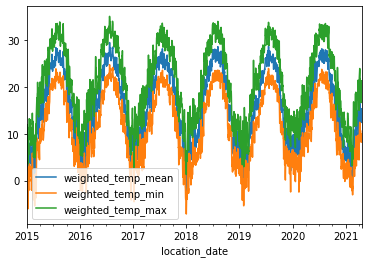

In [133]:
%matplotlib inline
plotting_df[['weighted_temp_mean', 'weighted_temp_min', 'weighted_temp_max']].plot()

# Season Avg

In [ ]:
SUMMER = ('June 20', 'Sep 22')
FALL = ('Sep 23', 'Dec 21')
WINTER = ('')

## Monthly Population Weighted Average, Max, and Min

<AxesSubplot:xlabel='location_date,location_date'>

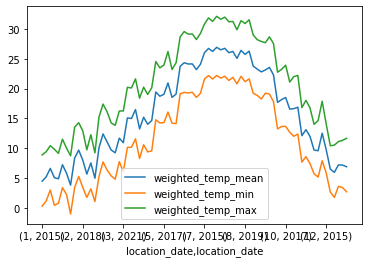

In [134]:
plotting_df.groupby([plotting_df.index.month, plotting_df.index.year]).agg({
    'weighted_temp_mean': np.mean,
    'weighted_temp_min': np.mean,
    'weighted_temp_max': np.mean
}).plot()

## Missing Data

In [254]:
import missingno as msno

In [259]:
reshaped_df.head()

temp_min_c                                                   \
station_code        KATL KBDL KBNA  KBOI KBOS  KBUF KBUR KBWI  KCMH  KCQT   
location_date                                                               
2015-01-01           0.0 -7.8 -5.0 -13.9 -5.6  -6.7 -0.6 -7.8  -7.2   3.3   
2015-01-02           6.7 -3.3  3.3 -13.3 -0.6  -5.0  0.6 -2.2  -3.9   3.9   
2015-01-03           8.9 -5.0  6.7 -10.6 -5.0  -5.6  2.8 -2.8  -1.1   4.4   
2015-01-04           6.7 -1.1 -2.2  -6.1  2.2  -2.2  3.3  3.9  -2.8   6.1   
2015-01-05           1.1 -9.4 -6.1  -1.7 -8.3 -12.8  6.7 -4.4 -11.0  10.6   

               ... population                                          \
station_code   ...       KPHL      KPHX      KPIT      KRDU      KRIC   
location_date  ...                                                      
2015-01-01     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
2015-01-02     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
2015-01-03     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
2015-01-04     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   
2015-01-05     ...  1536471.0  167721.0  307484.0  416468.0  144301.0   

                                                                 
station_code       KSAC      KSEA      KSFO      KSLC      KSTL  
location_date                                                    
2015-01-01     472178.0  620778.0  812826.0  189899.0  318069.0  
2015-01-02     472178.0  620778.0  812826.0  189899.0  318069.0  
2015-01-03     472178.0  620778.0  812826.0  189899.0  318069.0  
2015-01-04     472178.0  620778.0  812826.0  189899.0  318069.0  
2015-01-05     472178.0  620778.0  812826.0  189899.0  318069.0  

[5 rows x 148 columns]

<AxesSubplot:>

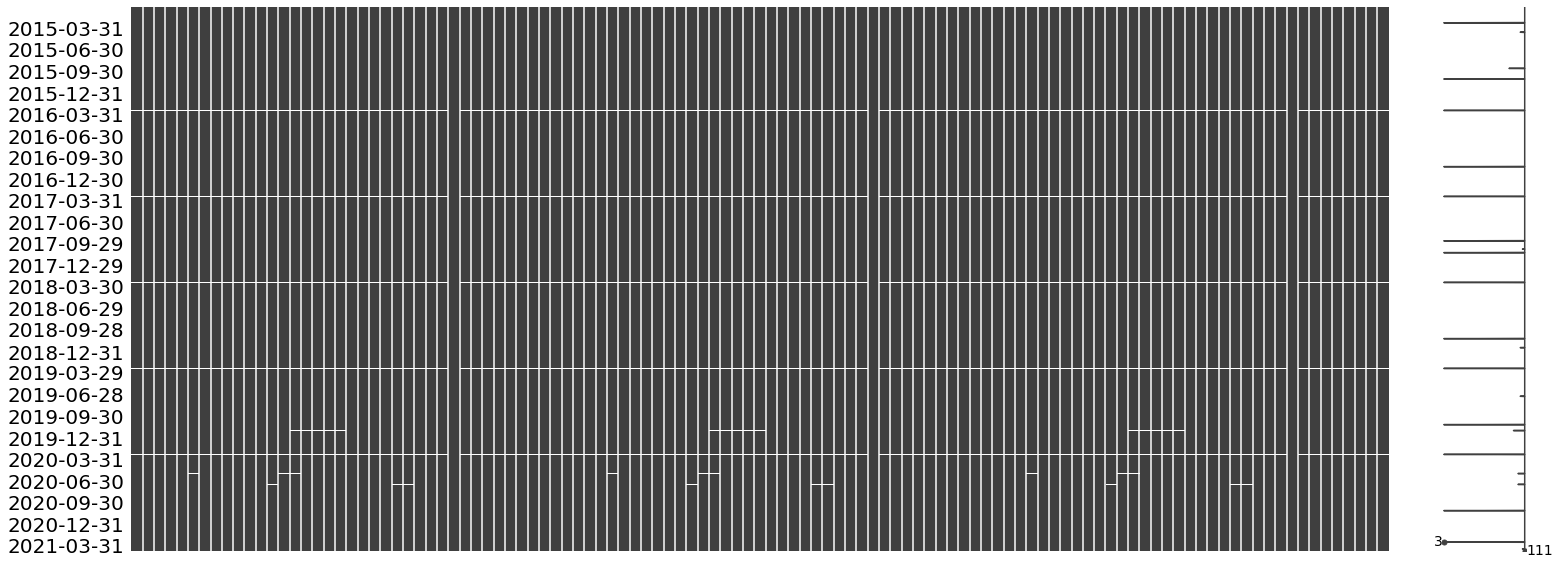

In [261]:
msno.matrix(reshaped_df[['temp_min_c', 'temp_max_c', 'temp_mean_c']], freq='BQ')